Two things. First, we can combine this optimization with the previous optimizations we did on max_depth and criterion. However, the search space is getting quite large, so we would need a plan to make our search computationally possible. Second: pruning (and other hyperparameter optimization) is often combined with a technique called _cross-validation_. Cross-validation improves our estimates of optimal parameters at the expense of extra computation time. Let's start by discussing the broader technique of bootstrapping.

### Bootstrapping

Now we discuss bootstrapping. Bootstrapping is a fundamental statistical technique, especially in nonparametric statistics. We use repeated sampling to empirically formulate estimates of population parameters without supposing a distribution.

In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# get the iris dataset
iris = pd.read_csv('https://gist.github.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv')
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


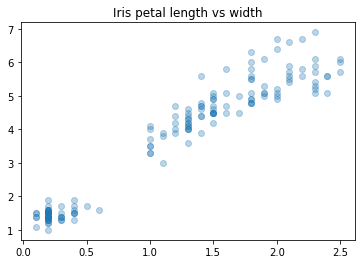

In [5]:
plt.scatter(iris['petal.width'],iris['petal.length'],alpha=0.3)
plt.title('Iris petal length vs width');

We'll randomly sample 500 points at a time (with repetition) from the iris dataset. For each sample, we will find the parameters of the line of best fit. We'll then study the collection of parameters generated.

In [12]:
intercepts = [] # to hold the y-intercepts of the lines of best fit
coefs = [] # to hold the slopes
# 1000 iterations: sample the data, fit a line, and get the parameters
for i in range(1000):
    choices = np.random.choice(range(150), size=50, replace=True)
    lr = LinearRegression()
    lr.fit(iris[['petal.width']].loc[choices],iris[['petal.length']].loc[choices])
    intercepts.append(lr.intercept_.item())
    coefs.append(lr.coef_.item())
# collect the parameter samples into a dataframe
reg_df = pd.DataFrame({'coef':coefs,'intercept':intercepts})

In [13]:
reg_df.head()

,coef,intercept
0,2.124098,1.292483
1,2.249479,1.096181
2,2.401059,0.931595
3,2.293938,1.064699
4,2.321992,1.080625


Next, for each x-value, we'll find a confidence interval for the predicted y-value based on our sample of lines of best fit.

In [14]:
# a function which will take a set of x-values and a dataframe with coef and intercept
# it will return a confidence interval of predictions for each x-value, with CI = 95 default
def minmax_preds(xs,df,CI = 95):
    mins = []
    maxes = []
    for x in xs:
        values = df['coef']*x+df['intercept']
        maxes.append(np.percentile(values,(100+CI)/2))
        mins.append(np.percentile(values,(100-CI)/2))
    return(mins,maxes)

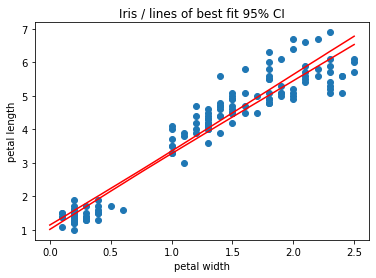

In [18]:
# define the xs to be the range of petal.width values
xs = np.linspace(0,max(iris['petal.width']),50)
ymins,ymaxes = minmax_preds(xs,reg_df,50)

# plot the lower and upper bounds of the line predictions for each x-value
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(xs,ymins,color = '#FF0000')
ax.plot(xs,ymaxes,color = '#FF0000')
ax.scatter(iris['petal.width'],iris['petal.length'])
ax.set_title('Iris / lines of best fit 95% CI')
ax.set_xlabel('petal width')
ax.set_ylabel('petal length');

### Cross-validation

k-fold cross-validation is a sort of bootstrapping. It means after splitting off the test data from a dataset, breaking the remainder into k evenly-sized pieces. Each of the k pieces is, in turn, treated as a validation set, while the other k-1 pieces act as training sets. Doing so will give us a collection of parameters which can be averaged. This approach is less prone to overfit since it uses several training sets. Let's use k-fold cross validation on the iris set.

In [19]:
from sklearn.model_selection import KFold, train_test_split

In [20]:
x_tr,x_te,y_tr,y_te = train_test_split(iris[['petal.width']],iris[['petal.length']],
                                      test_size = 0.2,random_state = 0)

We'll use KFold to define a k-fold cross-validation set. If randomization is important, we need to randomize our data first, or else use KFold's optional argument shuffle = True. Since our train_test_split call randomized our initial dataset, we do not need to use KFold's shuffle.

Note also that kf will give a split of the row numbers of the input, not the actual index. So, we use the generated indices with iloc, not loc.

In [21]:
kf = KFold(n_splits=3) # by default, the input will not be shuffled!
kf.get_n_splits(x_tr) # define splits on the x_tr row numbers.
# kf.split(x_tr) returns a generator. let's investigate:
for i, (train_index, val_index) in enumerate(kf.split(x_tr)):
    print(f'FOLD {i}:\n')
    print(f'  TRAIN INDEX={train_index}\n')
    print(f'  VAL INDEX={val_index}\n\n')

FOLD 0:

  TRAIN INDEX=[ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119]

  VAL INDEX=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


FOLD 1:

  TRAIN INDEX=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119]

  VAL INDEX=[40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]


FOLD 2:

  TRAIN INDEX=[ 0

In [24]:
coefs = []
intercepts = []
for train_index,val_index in kf.split(x_tr):
    lr.fit(x_tr.iloc[train_index],y_tr.iloc[train_index])
    coefs.append(lr.coef_)
    intercepts.append(lr.intercept_)

In [25]:
coef = round(np.mean(coefs),3)
intercept = round(np.mean(intercepts),3)
print(f'coef: {coef}\nintercept: {intercept}')

coef: 2.228
intercept: 1.073


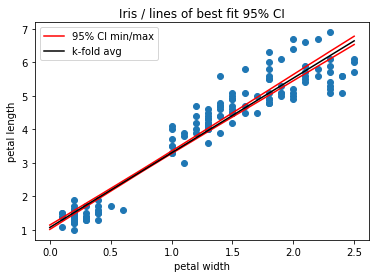

In [27]:
# plot the k-folds average line of best fit vs the 95% CI min/max
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(xs,ymins,color = '#FF0000',label = '95% CI min/max')
ax.plot(xs,ymaxes,color = '#FF0000')
ax.scatter(iris['petal.width'],iris['petal.length'])
ax.plot(xs,[x*coef+intercept for x in xs],color = '#000000',label = 'k-fold avg')
ax.set_title('Iris / lines of best fit 95% CI')
ax.set_xlabel('petal width')
ax.set_ylabel('petal length')
ax.legend();

Now we use bootstrapping with k-fold cross-validation to get a confidence interval for the line of best fit.

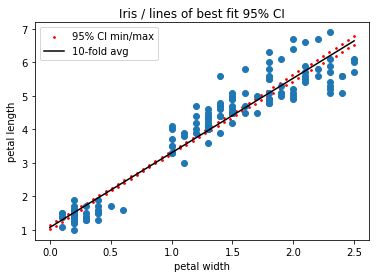

In [28]:
# now with more folds!
folds = 10
kf = KFold(n_splits=folds)
kf.get_n_splits(x_tr)
coefs = []
intercepts = []
for fold,(train_index,val_index) in enumerate(kf.split(x_tr)):
    lr.fit(x_tr.iloc[train_index],y_tr.iloc[train_index])
    coefs.append(lr.coef_)
    intercepts.append(lr.intercept_)
fig,ax = plt.subplots(figsize = (6,4))
ax.scatter(xs,ymins,s=3,color = '#FF0000',label = '95% CI min/max')
ax.scatter(xs,ymaxes,s=3,color = '#FF0000')
ax.scatter(iris['petal.width'],iris['petal.length'])
ax.plot(xs,[x*coef+intercept for x in xs],color = '#000000',label = f'{folds}-fold avg')
ax.set_title('Iris / lines of best fit 95% CI')
ax.set_xlabel('petal width')
ax.set_ylabel('petal length')
ax.legend();